In [3]:
import sys
import os
sys.path.append("pathto/utils")
import cellDensity
import draw
import clus
import matplotlib.pyplot as plt
import scanpy as sc
import numpy as np
import pandas as pd
from tqdm import tqdm 
import seaborn as sns

In [28]:
seq = ["T57","T55", "T53","T49", "T47", "T43", "T41", "T39", "T37", "T33", "T31", 
 "T27", "T25", "T30", "T32", "T34", "T36", "T40", "T42", "T44", "T48", "T50", "T52"]

adatas = {} 
adatacells = {}

for i in seq:
    adatas[i] = sc.read_h5ad("pathto/HIP_macaque/bin50/macaque1/%s.h5ad"%i)
    adatacells[i] = sc.read_h5ad("pathto/HIP_macaque/cell/macaque1_926/%s.h5ad"%i)
    

In [29]:
densities ={}
for i in tqdm(seq):
    adatabin50 = adatas[i]
    adatacell = adatacells[i]
    adatacell.obs["Cell_Type"] = adatacell.obs["rename"]
    adatabin50.obs["x"] = adatabin50.obsm["spatial"][:, 0] - np.min(adatabin50.obsm["spatial"][:, 0]) + 2
    adatabin50.obs["y"] = adatabin50.obsm["spatial"][:, 1] - np.min(adatabin50.obsm["spatial"][:, 1]) + 2

    adatacell.obs["x"] = adatacell.obsm["spatial"][:, 0] // 50 
    adatacell.obs["y"] = adatacell.obsm["spatial"][:, 1] // 50

    adatacell.obs["x"] = adatacell.obs["x"] - np.min(adatacell.obs["x"]) + 2 
    adatacell.obs["y"] = adatacell.obs["y"] - np.min(adatacell.obs["y"]) + 2

    adatacelldensity = cellDensity.df2adata(adatacell.obs, adatabin50)
    adatacelldensity = clus.smoothadata(adatacelldensity, s = 3) 
    densities[i] = adatacelldensity

  0%|          | 0/24 [00:00<?, ?it/s]/home/feity/HCgit/utils/cellDensity.py:38: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = anndata.AnnData(g)
/home/feity/.conda/envs/tf/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
100%|██████████| 24/24 [00:54<00:00,  2.29s/it]


In [55]:
res = {}
for i in densities:
    adata = densities[i]
    df = pd.DataFrame(adata.X, columns=adata.var_names)
    total_cells = len(adatacells[i])
    df = df/(total_cells/len(df))
    
    # you can use the second momentum, which places more emphasis on cell aggregation. 
    # df *= df
    # df = df.replace(0, np.nan)
    
    res[i] = df.mean(skipna=True)

In [56]:
neuron_df_macaque = pd.DataFrame(res)
neuron_df_macaque = neuron_df_macaque.fillna(0)

df = pd.read_excel("/home/feity/HCgit/TableS1.xlsx", sheet_name="macaque")
df["EBZ"] = df["EBZ (mm)"].astype(float)
dfEBZ = df.set_index("chipID")

In [57]:
from scipy.ndimage import gaussian_filter1d
v = neuron_df_macaque.values
for i in range(len(neuron_df_macaque)):
    v[i, :] = gaussian_filter1d(v[i, :], 1)
neuron_df_macaque = pd.DataFrame(v, index=neuron_df_macaque.index, columns=neuron_df_macaque.columns)

In [58]:
total_seq = ['Glu pSUB-deep-1', 'Glu pSUB-deep-2', 'Glu pSUB-deep-3', 'Glu pSUB-int-1', 'Glu pSUB-int-2', 'Glu pSUB-int-3',
        'Glu pSUB-int-4', 'Glu pSUB-int-5', 'Glu pSUB-int-6', 'Glu pSUB-int-7']#, 'Glu pSUB-int-8']
neuron_df_macaque = neuron_df_macaque.loc[total_seq]
neuron_df_macaque = np.log(neuron_df_macaque + 0.00001)# -np.min(np.log(neuron_df + 0.00001))
neuron_df_macaque = neuron_df_macaque.subtract(neuron_df_macaque.min(axis=1), axis=0)

In [59]:
v = neuron_df_macaque.values
w = [] 
for i in range(len(neuron_df_macaque)):
    w.append(np.average(np.array(range(len(neuron_df_macaque.columns))), weights=v[i, :]))
ii = (w-np.min(w))/(np.max(w) - np.min(w)) 

b = np.array((0.2528186785662627, 0.6322661966470429, 0.9586861264495917))
r = np.array((0.9692894417585417, 0.4522225702495641, 0.4261820543616833))
palette = []  
for i in ii:
    palette.append(b*i+r*(1-i))

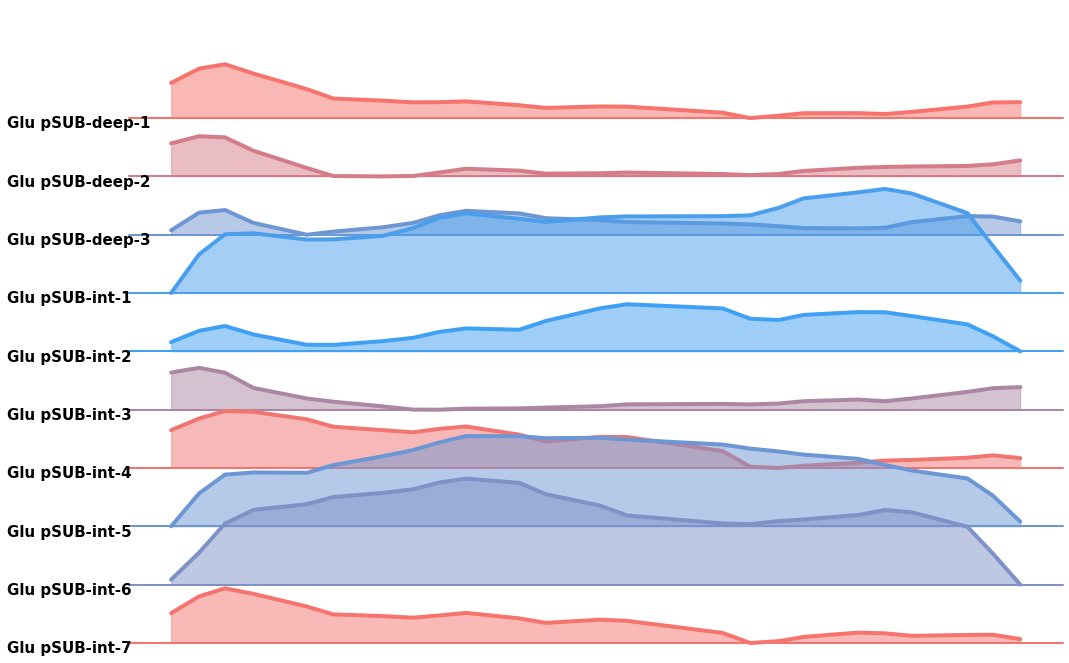

In [60]:
longdf = draw.prepareLongTable(neuron_df_macaque, dfEBZ)
draw.drawFacet(longdf, palette)

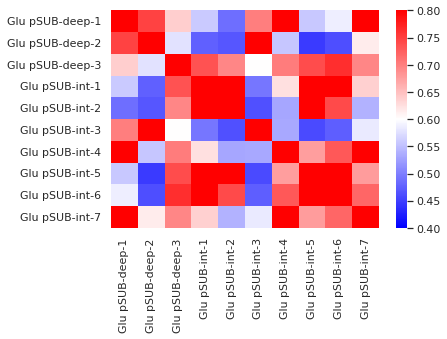

In [36]:
neuron_df_macaque = neuron_df_macaque.div(neuron_df_macaque.sum(axis=1), axis=0)
mat = np.zeros((len(total_seq), len(total_seq)))
for i in range(len(total_seq)):
    for j in range(len(total_seq)):
        sub = neuron_df_macaque.loc[[total_seq[i], total_seq[j]]]
        t = sub.min(axis=0)
        mat[i, j] = t.sum()
        
sns.heatmap(mat, xticklabels=neuron_df_macaque.index, yticklabels=neuron_df_macaque.index, cmap="bwr", vmax=0.8, vmin=0.4)